# Writing efficient DOcplex code

In this notebook, we show how to improve efficiency of DOcplex models using five simple rules.

## A simple timing tool

To measure performance we need a simple timing tool. For this purpose, we chose to implement a Python context manager object (see https://docs.python.org/3/reference/datamodel.html#context-managers) for details.

This object stores the start time when entering a block and reports time spent when exiting the block. Python's `with` statement avoids cluttering code with intrusive prints.

In [1]:
import time
import math

class ContextTimer(object):
    def __init__(self, msg):
        self.msg = msg
        self.start = 0
        
    def __enter__(self):
        self.start = time.time()
        return self  # return value is value of with ()
        
    def __exit__(self, *args):
        elapsed = time.time() - self.start
        self.msecs = math.ceil(1000* elapsed)
        print('<-- {0},  time: {1:.0f} ms'.format(self.msg, self.msecs))   
        
# try our timer on computing fibonacci numbers
def fib(n):
    return 1 if n <= 2 else  fib(n-1) + fib(n-2)

# timing fibonacci(30)
with ContextTimer("fibonacci 30"):
    n = 30
    f = fib(n)
    print("fibonacci({0}) = {1}".format(n, f))
        

fibonacci(30) = 832040
<-- fibonacci 30,  time: 277 ms


## The benchmark model

To compare various implementations, we need a simple, scalable benchmark model. The model has no real business meaning, but is simple to grasp
and can be scaled by changing one `size` parameter.
Note that we'll be comparing only the _build_ time of the model, not the _solve_ time.

Note that the model has _n_ constraints, all with expressions of size _N_, so we expect the underlying matrix _size_ to grow as $O(N^2)$.

### Description

Let $N$ be an integer (the size of the problem).

$$
minimize \sum_{k=0}^{k=N-1} (k+1) * y_{k}\\
s.t.\\
\forall\ \ m\ in \{0..N-1\}\ \ \sum_{l=0}^{l=N-1} (y_{l} * (l+ (l+m) \%3) \ge l\\
y_{k} = 0, 1
$$

## A beginners's implementation of the model

In this section we show a Python/Docplex beginner's implementation of this model.


In [2]:
from docplex.mp.model import Model

def build_bench_model1(size=10):
    m = Model(name="bench1")
    rsize = range(size)
    # create variables as a dictionary indexed by the range
    ys = m.binary_var_dict(rsize, name="y")
    # create constraints
    k = {(i,j) : (i + (i+j) %3) for i in rsize for j in rsize}
    for i in rsize:
        m.add(m.sum(ys[i] * k[i,j] for j in rsize) >= i, "ct_%d" %i)
    # for minimize, create a list of coefficients
    rsize1 = [i+1 for i in rsize]
    m.minimize(m.sum(ys[k] * rsize[k] for k in rsize))
    return m

Lets run our context timer with N=1000; we expect a model with 1000 variables and 1000 constraints:

In [3]:
with ContextTimer("bench1_size_1000"):
    m11k = build_bench_model1(1000)
m11k.print_information()

<-- bench1_size_1000,  time: 4602 ms
Model: bench1
 - number of variables: 1000
   - binary=1000, integer=0, continuous=0
 - number of constraints: 1000
   - linear=1000
 - parameters: defaults


As expected the model has 1000 variables and 1000 constraints and the build time is significant.
For N=3000, we can expect an increase in buid time by a factor of 9:

In [4]:
N=3000
with ContextTimer("bench1 size={0}".format(N)):
    build_bench_model1(N)

<-- bench1 size=3000,  time: 41211 ms


# Seven tips to improve DOcplex code efficiency

## Use scalar product

When building large expressions,  scalar product (`Model.scal_prod()`) is 
an efficient way to combine a sequence of variables (or expressions)
and a sequence of coefficients.
Try using `scalar_prod` instead of using `for` loops in expressions.

In [5]:
def build_bench_model2(size=10):
    m = Model(name="bench2")
    rsize = range(size)
    # create variables as a dictionary indexed by the range
    ys = m.binary_var_dict(rsize, name="y")
    # create constraints
    k = {(i,j) : (i + (i+j) %3) for i in rsize for j in rsize}
    for i in rsize:
        m.add(m.scal_prod([ys[i1] for i1 in rsize], [k[i,j] for j in rsize]) >= i, "ct_%d" % i)
    # for minimize, create a list of coefficients
    rsize1 = [i+1 for i in rsize]
    m.minimize(m.scal_prod([ys[k] for k in rsize], rsize1))
    return m

with ContextTimer("bench3 size={0}".format(N)):
    build_bench_model2(N)

<-- bench3 size=3000,  time: 25222 ms


### Use variable lists instead of dicts, if possible

In the previous examples, we had to create an auxiliary sequence from the variable dictionary to pass to `scal_prod`. Actually, a variable _list_ would be much simpler to use than the dictionary, so we replace the `var_dict` by a `var_list`

In [6]:
def build_bench_model21(size=10):
    m = Model(name="bench2.1")
    rsize = range(size)
    # create variables as a dictionary indexed by the range
    ys = m.binary_var_list(rsize, name="y")
    # create constraints
    k = {(i,j) : (i + (i+j) %3) for i in rsize for j in rsize}
    for i in rsize:
        m.add(m.scal_prod(ys, [k[i,j] for j in rsize]) >= i, "ct_%d" % i)
    # for minimize, create a list of coefficients
    rsize1 = [i+1 for i in rsize]
    m.minimize(m.scal_prod(ys, rsize1))
    return m

with ContextTimer("bench2.1 size={0}".format(N)):
    build_bench_model21(N)

<-- bench2.1 size=3000,  time: 24599 ms


## Use batches of constraints

Adding constraints to the model by batches using `Model.add_constraints()`
is usually more efficient.
Try grouping consttraints in lists or comprehensions (both work).

If the constraints are named, pass a second argument with the collection of constraint names.

In [7]:
def build_bench_model3(size=10):
    m = Model(name="bench3")
    rsize = range(size)
    # create variables as a dictionary indexed by the range
    ys = m.binary_var_list(rsize, name="y")
    # create constraints
    k = {(i,j) : (i + (i+j) %3) for i in rsize for j in rsize}
    m.add_constraints((m.scal_prod(ys, [k[i,j] for j in rsize]) >= i for i in rsize),
                     ["ct_%d" % i for i in rsize])
    # for minimize, create a list of coefficients
    rsize1 = [i+1 for i in rsize]
    m.minimize(m.scal_prod(ys, rsize1))
    return m

with ContextTimer("bench3 size={0}".format(N)):
    build_bench_model3(N)

<-- bench3 size=3000,  time: 24341 ms


## Avoid creating unnecessary containers

The previous version allocated one dictionary `k` for coefficients and an auxiliary list for the objective. We can simplify the code bys using comprehensions instead.

In [8]:
def build_bench_model4(size=10):
    m = Model(name="bench4")
    rsize = range(size)
    # create variables as a dictionary indexed by the range
    ys = m.binary_var_list(rsize, name="y")
    # create constraints
    m.add_constraints((m.scal_prod(ys, [(i+ (i+j)%3) for j in rsize]) >= i for i in rsize),
                     ("ct_%d" % i for i in rsize))
    # for minimize, create a list of coefficients
    m.minimize(m.scal_prod(ys, (i+1 for i in rsize)))
    return m

with ContextTimer("bench4 size={0}".format(N)):
    build_bench_model4(N)

<-- bench4 size=3000,  time: 20162 ms


## Take control of name generation

Naming variables and/or constraints is useful to generate readable LP files. However, generating lare numbers of strings may have a significant cost in Python, sepcially for large models. 

DOcplex provides a keyword `ignore_names` at model creation time, which may disable all names (variables and constraint names alike) that are set in the model. 

By default, this flag is  `False`, and names are enabled. By setting this flag to `True`, all names mentioned in the model are discarded (in particular, names are not used in LP generation).

In the next version we simply add the `ignore_names=True` keyword argument to the model constructor

In [9]:
def build_bench_model5(size=10):
    m = Model(name="bench5", ignore_names=True)
    rsize = range(size)
    # create variables as a dictionary indexed by the range
    ys = m.binary_var_list(rsize, name="y")
    # create constraints
    m.add_constraints((m.scal_prod(ys, [(i+ (i+j)%3) for j in rsize]) >= i for i in rsize),
                     ("ct_%d" % i for i in rsize))
    # for minimize, create a list of coefficients
    m.minimize(m.scal_prod(ys, (i+1 for i in rsize)))
    return m

with ContextTimer("bench6 size={0}".format(N)):
    build_bench_model5(N)

<-- bench6 size=3000,  time: 19171 ms


## Take control of argument checking

DOcplex does a minimal checking on arguments. As this can be useful when writing the model to avoid errors, this checking has a runtime cost. When running a deployed model that has been thoroughly tested and tuned, you can remove all checks by adding the `checker="off"` keyword argument to the model constructor.

Again, the next version is identical to the previous one , except that type-checking has been disabled.

In [10]:
def build_bench_model6(size=10):
    m = Model(name="bench6", ignore_names=True, checker="off")
    rsize = range(size)
    # create variables as a dictionary indexed by the range
    ys = m.binary_var_list(rsize, name="y")
    # create constraints
    m.add_constraints((m.scal_prod(ys, [(i+ (i+j)%3) for j in rsize]) >= i for i in rsize),
                     ("ct_%d" % i for i in rsize))
    # for minimize, create a list of coefficients
    m.minimize(m.scal_prod(ys, (i+1 for i in rsize)))
    return m

with ContextTimer("bench6 size={0}".format(N)):
    build_bench_model6(N)

<-- bench6 size=3000,  time: 14026 ms


## Use the "advanced model" class

DOcplex contains and `AdvModel` class, which is a subclass of `Model`.
This class contains highly efficient methods for special cases, for examples, scalar prodicts with all different variables. 
By default, `AdvModel` methods do not perform any checking on their arguments. For example, the `cal_prod_vars_all_different` method does not check that the variables are indeed all different. If this is not true, then errors or incorrect results may occur.

Still, you can enable type-checking on AdvModel by specifying `checker="on"` at construction time, and remove it later.

The benchmark model is a good fit for the `scal_prod_vars_all_different` method as all our scalar products involve the `ys` variables.

AdvModel provides other specialized fast method, among them:

 - `sum_vars_all_different` to compute the sum of a sequence of all different variables.
 - `quad_matrix_sum` to compute a quadratic expression from a matrix $Q$ and a vector of variables $X$ as $X^{t}QX$
 - `vector_compare` to compute a sequence of linear constraint from two sequences of expressions


In [11]:
from docplex.mp.advmodel import AdvModel

def build_bench_model7(size=10):
    m = AdvModel(name="bench7", ignore_names=True, checker='off')
    rsize = range(size)
    # create variables as a dictionary indexed by the range
    ys = m.binary_var_list(rsize, name="y")
    # create constraints
    m.add_constraints((m.scal_prod_vars_all_different(ys, [(i+ (i+j)%3) for j in rsize]) >= i for i in rsize),
                 ("ct_%d" % i for i in rsize))
    
    # for minimize, use comprehension
    m.minimize(m.scal_prod_vars_all_different(ys, (i+1 for i in rsize)))
    return m

with ContextTimer("bench7 size={0}".format(N)):
    build_bench_model7(N)

<-- bench7 size=3000,  time: 10350 ms


# Summary

From version 1 to version 7 , model build time has decreased from 35s to 4s (on our platform). Result smay well differ on other platforms, but still, this demonstrates that the way the model is built can greatly influence the performance.

Here is a list of tricks to try to improve model building time:

 - Use Model.scal_prod wherever possible
 - Add constraints in batches, not one by one
 - Leverage Python comprehensions to avoid unnecessary data structures
 - Try ignoring name generation (for large models)
 - Try disabling all argument checking
 - Eventually, look at specialized methods in the `AdvModel` class.

## Plotting the trend

In this section we compute the times to build different model versions on various sizes, and
plot the result on a graph.
This code requires the `matplotlib` library to run.

**Note**: the next cell might take a significant time to run, as it
runs a lot of (size, model_build_function) combinations...

In [17]:
# various sizes to sample performance
sizes = [100, 300, 600, 1000, 3000, 5000]

# a lits of tuples (fn, label) to build model and an explanatory label
builders = [(build_bench_model1, "initial"), 
            (build_bench_model2, "scal_prod"),
            (build_bench_model4, "batch_cts"),
            (build_bench_model5, "ignore_names"),
            (build_bench_model6, "checker_off"),
            (build_bench_model7, "advmodel")]
print("* start computing performance data")
res = {}
print("* start computing results...")
nb_runs = len(sizes) * len(builders)
r = 0
for s in sizes:
    for b, (bf, _) in enumerate(builders):
        r +=1 
        with ContextTimer("[{2}/{3}] use {0} with size={1}"
                          .format(bf.__name__, s, r, nb_runs)) as tt:
            m = bf(s)
            m.end()
        elapsed = tt.msecs
        res[b, s] = tt.msecs
print("* end computing results")
# now we have a dict of (#builder, size) -> time

* start computing performance data
* start computing results...
<-- [1/36] use build_bench_model1 with size=100,  time: 71 ms
<-- [2/36] use build_bench_model2 with size=100,  time: 40 ms
<-- [3/36] use build_bench_model4 with size=100,  time: 40 ms
<-- [4/36] use build_bench_model5 with size=100,  time: 41 ms
<-- [5/36] use build_bench_model6 with size=100,  time: 30 ms
<-- [6/36] use build_bench_model7 with size=100,  time: 20 ms
<-- [7/36] use build_bench_model1 with size=300,  time: 397 ms
<-- [8/36] use build_bench_model2 with size=300,  time: 218 ms
<-- [9/36] use build_bench_model4 with size=300,  time: 170 ms
<-- [10/36] use build_bench_model5 with size=300,  time: 161 ms
<-- [11/36] use build_bench_model6 with size=300,  time: 131 ms
<-- [12/36] use build_bench_model7 with size=300,  time: 105 ms
<-- [13/36] use build_bench_model1 with size=600,  time: 1412 ms
<-- [14/36] use build_bench_model2 with size=600,  time: 921 ms
<-- [15/36] use build_bench_model4 with size=600,  tim

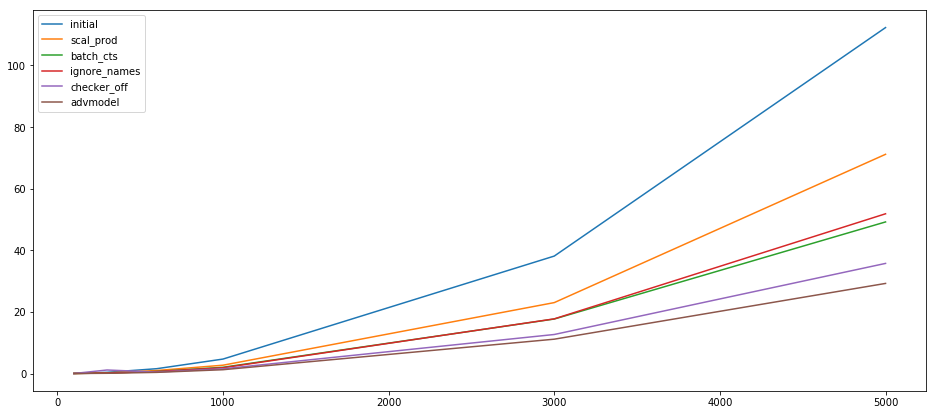

In [13]:
try:
    import matplotlib.pyplot as plt
    %matplotlib inline
except ImportError:
    print("try install matplotlib: pip install matplotlib")
    raise


labels = [ bl for (_, bl) in builders]
plt.figure(figsize=(16,7))
for b in range(len(builders)):
    bts = [res[b,s]/1000 for s in sizes]
    plt.plot(sizes, bts, label=labels[b])
    plt.legend()

plt.show()

## Average improvement

In the next cell, we compute the geometric mean of improvment between the first and last versions. Of course, results may differ depending on platform (and the model, too) but the idea is, applying the above rules may yield a significant improvement

In [14]:
# compute geomerical mean for all sizes
nb_builders = len(builders)
ratios = {}
for s in sizes:
    initial = res[0, s]
    final = res[nb_builders-1, s]
    r = (initial/final)
    ratios[s] = r
import math
rgm = math.exp(sum(math.log(r) for r in ratios.values()) / float(nb_builders))
print("* geometric mean of time improvement is {0:.1f}".format(rgm))

* geometric mean of time improvement is 3.5
